In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

# For data preparation
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# For Tensorflow
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, MaxPool1D, GlobalAvgPool1D, Conv1D, Dropout, BatchNormalization

# for callback
from tensorflow.keras.callbacks import ModelCheckpoint

L'objectif à travers ce code est de prendre les 8 signaux directement et de les faire rentrer dans un CNN à 1 dimension

In [2]:
monfichier = pd.read_csv("./capteurs/capteur1.csv")
macolonne = monfichier["class"]
macolonne.to_csv("./capteurs/labels/labels.csv", index=None)

In [3]:
def stack_dataset(path, test_size=0.3) :
    listefichier = os.listdir(path)
    monDataset = list()
    etiq = 0
    for file in listefichier :
        all_path = os.path.join(path,file)
        if not os.path.isdir(all_path) :
            monfichier = pd.read_csv(all_path)
            monfichier.drop(["class"], axis=1, inplace=True)
            monDataset.append(monfichier)
        else :
            monfichier = os.listdir(all_path)
            all_path_etiq = os.path.join(all_path,monfichier[0])
            etiq = pd.read_csv(all_path_etiq)
            etiq["class"] = etiq["class"].astype('category').cat.codes
    monDataset = np.dstack(monDataset)
    fv_train, fv_test, etiq_train, etiq_test = train_test_split(monDataset, etiq, test_size=test_size, random_state=42)
    return fv_train, fv_test, etiq_train, etiq_test

TODO : AJOUTER UN MINMAX SCALER

In [4]:
fv_train, fv_test, etiq_train, etiq_test = stack_dataset("./capteurs")
fv_train.shape, fv_test.shape, etiq_train.shape, etiq_test.shape

((54, 4000, 8), (24, 4000, 8), (54, 1), (24, 1))

Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 1.2856 - accuracy: 0.4651
Epoch 1: accuracy improved from -inf to 0.46512, saving model to .\Model_CNN1D_all
INFO:tensorflow:Assets written to: .\Model_CNN1D_all\assets
11/11 [==============================] - 8s 538ms/step - loss: 1.2856 - accuracy: 0.4651 - val_loss: 1.3048 - val_accuracy: 0.4545
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 1.0603 - accuracy: 0.6744
Epoch 2: accuracy improved from 0.46512 to 0.67442, saving model to .\Model_CNN1D_all
INFO:tensorflow:Assets written to: .\Model_CNN1D_all\assets
11/11 [==============================] - 5s 519ms/step - loss: 1.0603 - accuracy: 0.6744 - val_loss: 1.2614 - val_accuracy: 0.5455
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 0.9255 - accuracy: 0.6744
Epoch 3: accuracy did not improve from 0.67442
11/11 [==============================] - 1s 101ms/step - loss: 0.9255 - accuracy: 0.6744 - val_loss: 1.1225 - val_accura

Text(0.5, 8.959999999999994, 'Predicted label')

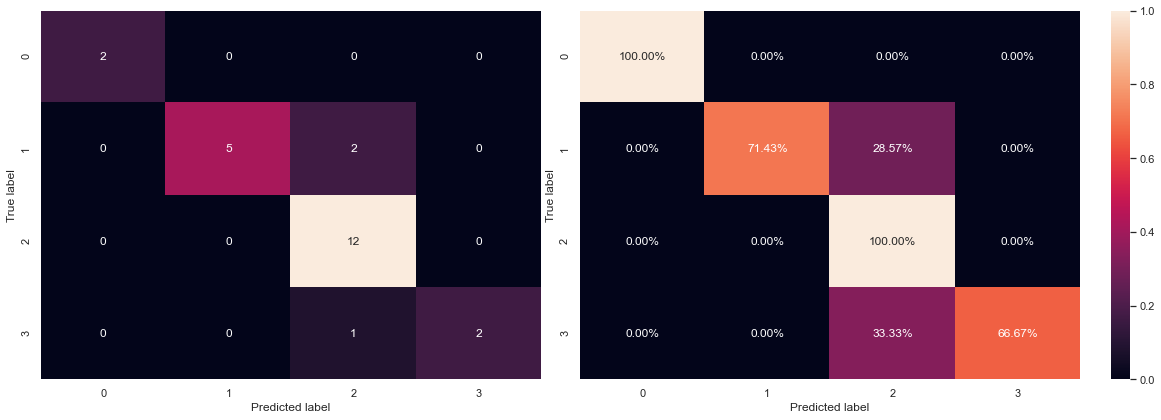

In [5]:
    # CNN Variables
    # Première couche du CNN
filter_size1 = 5
num_filters1 = 64
    # Deuxième couche du CNN 
filter_size2 = 5
num_filters2 = 32

batch_size = 4
num_channels = fv_train.shape[2] # ! paramètre sur lequel on pourrait jouer si on ajoute les autres capteurs
n_epochs = 50
signal = fv_train.shape[1]
    

# CNN
path_to_save_model = './Model_CNN1D_all'

ckpt_saver = ModelCheckpoint(
path_to_save_model,
monitor='accuracy', # sur quoi on se base pour voir le meilleur
mode = 'max', # max de l'accuracy sur la validation
save_best_only = True,
save_freq='epoch', # ne voit qu'à la fin de l'époque
verbose=1) 


model = tf.keras.Sequential(
[
    Input(shape=(signal,num_channels)), # format d'entrée
    Conv1D(filters=num_filters1, kernel_size=filter_size1, activation='relu'),
    Conv1D(filters=num_filters2, kernel_size=filter_size2, activation='relu'),
    Dropout(0.5),
    MaxPool1D(pool_size=2),
    #BatchNormalization(),
    Conv1D(filters=num_filters1, kernel_size=filter_size1, activation='relu'),
    Conv1D(filters=num_filters2, kernel_size=filter_size1, activation='relu'),
    Dropout(0.5),
    MaxPool1D(pool_size=2),
    #BatchNormalization(),
    GlobalAvgPool1D(),
    Dense(50, activation='relu'),
    Dense(4, activation='softmax')
]
)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
model.fit(fv_train, etiq_train, batch_size=batch_size, epochs=n_epochs, validation_split=0.2, callbacks=[ckpt_saver])

# Evaluation of the model
print("\n\n==================================== Modele evaluation ====================================")
model.evaluate(fv_test,etiq_test, batch_size=batch_size)
print("===========================================================================================\n\n")
y_model=model.predict(fv_test)
y_model_max = np.argmax(y_model, axis=1)
con_mat = tf.math.confusion_matrix(labels=etiq_test, predictions=y_model_max).numpy()

cmn = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]
# Visualization
sns.set_theme(style='darkgrid')
plt.figure(figsize=(17, 6))
plt.subplot(1,2,1)
sns.heatmap(con_mat, annot=True)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.subplot(1,2,2)
sns.heatmap(cmn, annot=True, fmt='.2%')
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')